# Chess Tournament Analysis (CTA)
## Descripción
En este proyecto se busca hacer un analisis del torneo de Barcelona en especifico para luego poder escalarlo a otros torneos de ajedrez. Se busca analizar los datos de los jugadores, partidas y torneos para poder hacer un analisis de los jugadores y sus partidas.

## Objetivos
- Analizar los datos de los jugadores, partidas y torneos
- Realizar un analisis de los jugadores y sus partidas
- Realizar un analisis del torneo
- Analizar la evaluación del motor de ajedrez
- Analizar los movimientos más comunes
- Analizar las estrategias más comunes

## Datos
Los datos se encuentran en la carpeta `data` y se dividen en 3 archivos:
- `players.csv`: Contiene los datos de los jugadores
- `details.csv`: Contiene los datos de las partidas y la apertura realizada
- `moves.csv`: Contiene los datos de los movimientos, evaluación y tiempo de los movimientos
- `openings.csv`: Contiene los datos de las aperturas de ajedrez, el código de la apertura y el nombre de la apertura

## Estudios a realizar
- Rendimiento del jugador : Como se comporta el jugador en el torneo
- Efecto de la apertura en el resultado : Hay alguna apertura que sea mejor que otra para llegar a un mejor resultado
- Evaluación del motor de ajedrez : Como se comporta el motor de ajedrez en comparación con los jugadores profesionales
- Impacto del tiempo en el rendimiento : Cuanto influye el tiempo en el rendimiento del jugador
- Relación entre ELO y resultado : Existe una relación entre el ELO del jugador y el resultado obtenido
- Diferencia entre blancas y negras : Influencia de jugar con blancas o negras en el resultado


## Estudio de los datos
### Carga de los datos
Primero se cargan los datos de los jugadores, partidas, movimientos y aperturas.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
details_df = pd.read_csv("../data/details.csv")
moves_df = pd.read_csv("../data/moves.csv")
openings_df = pd.read_csv("../data/openings.csv")
players_df = pd.read_csv("../data/players.csv")

Segundo, se unen las tablas de jugadores con los detalles

In [5]:
# Unir detalles con jugadores
details_df = details_df.merge(players_df, left_on="White", right_on="FideId", suffixes=("_white", "_player"))
details_df = details_df.merge(players_df, left_on="Black", right_on="FideId", suffixes=("", "_black"))

details_df = details_df.rename(columns={"Name": "White_Player", "Name_black": "Black_Player", "Elo": "White_Elo", "Elo_black": "Black_Elo"})

details_df = details_df.merge(openings_df, on="ECO", how="left")

### Gráficas básicas
#### 1. Rendimiento de los jugadores

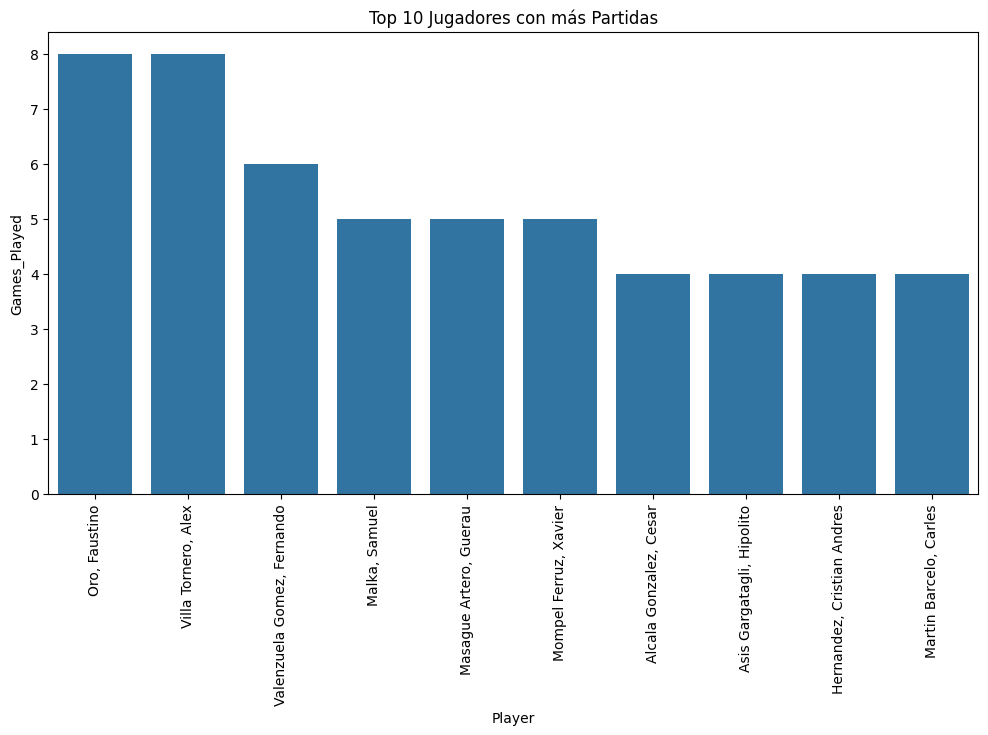

In [6]:
def player_performance():
    player_results = details_df.groupby("White_Player")["White_Elo"].count().reset_index()
    player_results.columns = ["Player", "Games_Played"]
    plt.figure(figsize=(12, 6))
    sns.barplot(data=player_results.sort_values("Games_Played", ascending=False).head(10), x="Player", y="Games_Played")
    plt.xticks(rotation=90)
    plt.title("Top 10 Jugadores con más Partidas")
    plt.show()

player_performance()

#### 2. Efecto de la apertura en el resultado

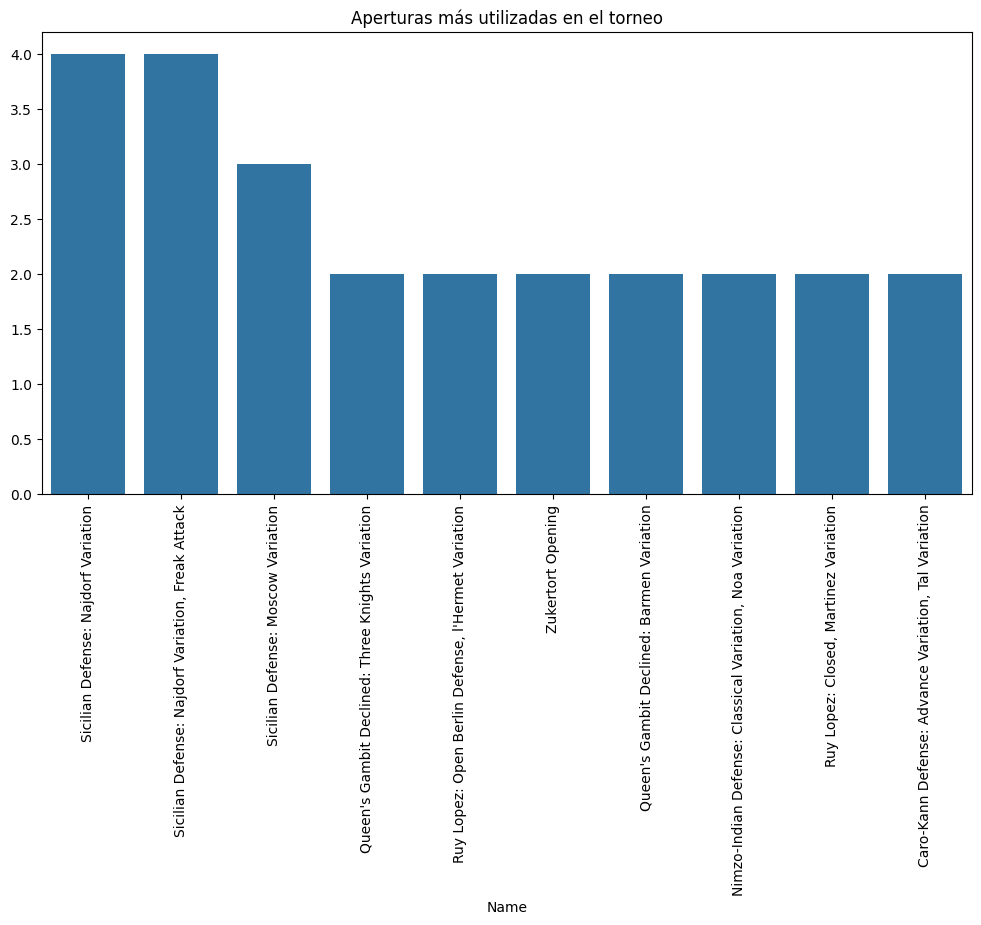

In [7]:
def opening_effect():
    opening_counts = details_df["Name"].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=opening_counts.index, y=opening_counts.values)
    plt.xticks(rotation=90)
    plt.title("Aperturas más utilizadas en el torneo")
    plt.show()

opening_effect()

#### 3. Evaluación del motor de ajedrez

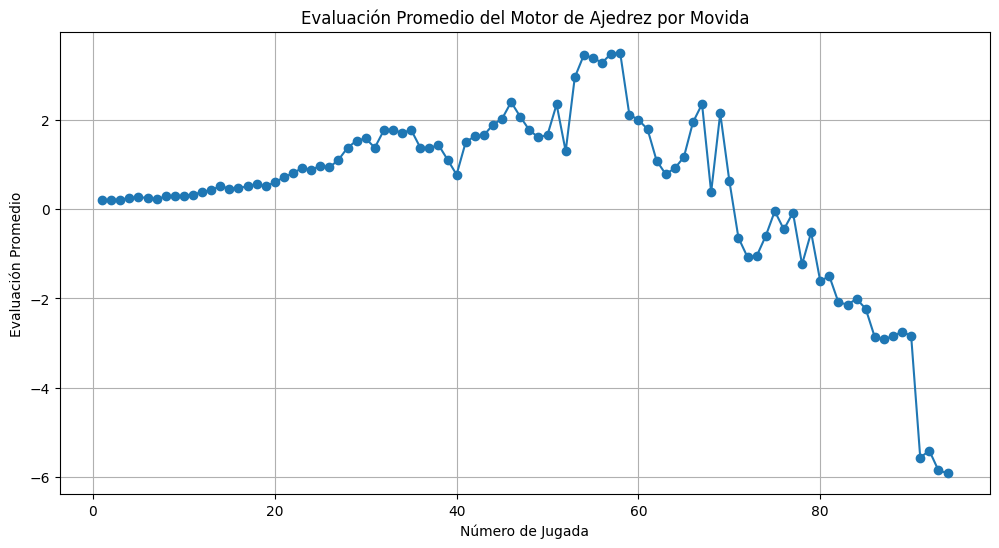

In [8]:
def engine_evaluation():
    avg_eval = moves_df.groupby("Move Number")["Evaluation"].mean()
    plt.figure(figsize=(12, 6))
    plt.plot(avg_eval.index, avg_eval.values, marker='o')
    plt.title("Evaluación Promedio del Motor de Ajedrez por Movida")
    plt.xlabel("Número de Jugada")
    plt.ylabel("Evaluación Promedio")
    plt.grid()
    plt.show()

engine_evaluation()

#### 4. Impacto del tiempo en el rendimiento

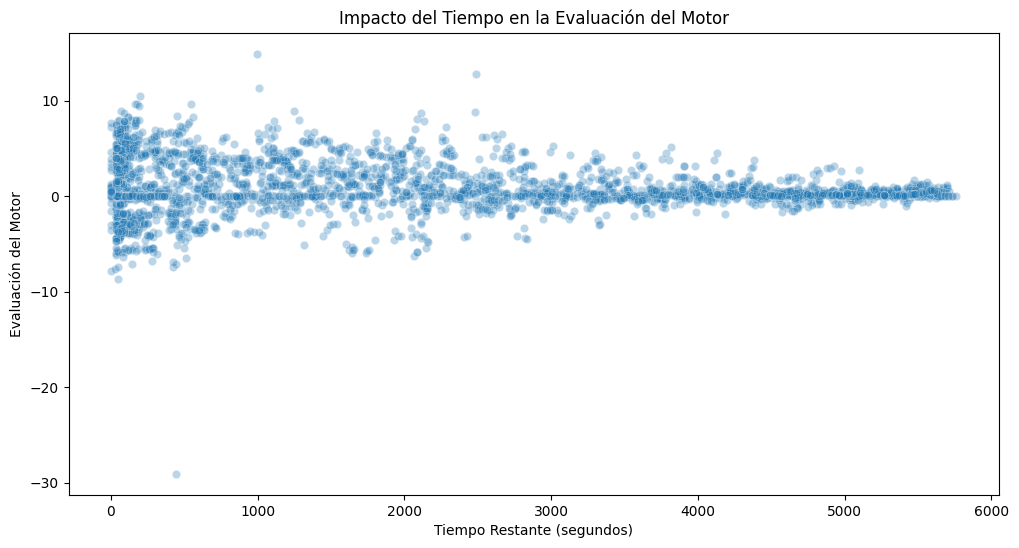

In [9]:
def time_impact():
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=moves_df, x="Time (seconds)", y="Evaluation", alpha=0.3)
    plt.title("Impacto del Tiempo en la Evaluación del Motor")
    plt.xlabel("Tiempo Restante (segundos)")
    plt.ylabel("Evaluación del Motor")
    plt.show()

time_impact()

#### 5. Relación entre ELO y resultado

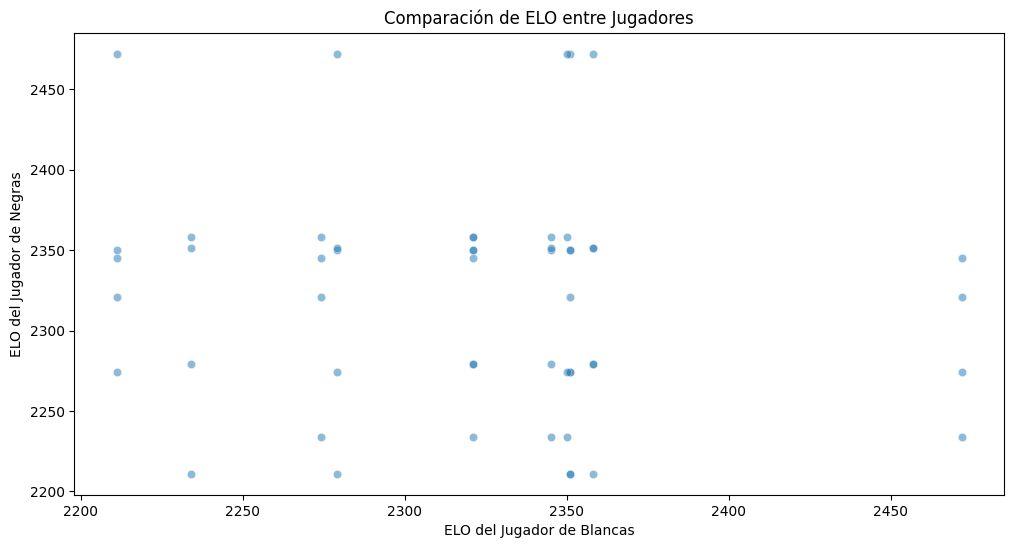

In [10]:
def elo_vs_result():
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=details_df, x="White_Elo", y="Black_Elo", alpha=0.5)
    plt.title("Comparación de ELO entre Jugadores")
    plt.xlabel("ELO del Jugador de Blancas")
    plt.ylabel("ELO del Jugador de Negras")
    plt.show()

elo_vs_result()

#### 6. Diferencia entre blancas y negras

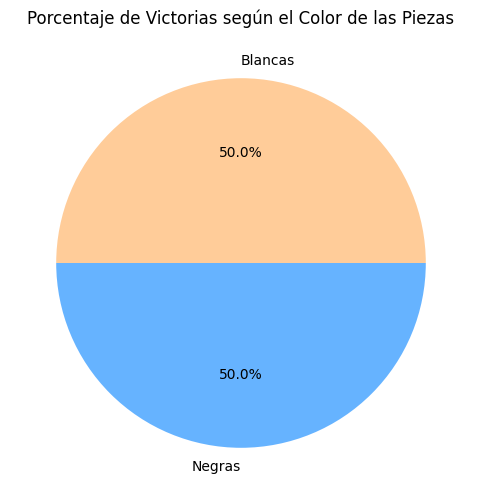

In [11]:
def color_advantage():
    white_wins = details_df["White_Elo"].count()
    black_wins = details_df["Black_Elo"].count()
    plt.figure(figsize=(6, 6))
    plt.pie([white_wins, black_wins], labels=["Blancas", "Negras"], autopct="%.1f%%", colors=["#ffcc99", "#66b3ff"])
    plt.title("Porcentaje de Victorias según el Color de las Piezas")
    plt.show()

color_advantage()